<a href="https://colab.research.google.com/github/vngabriel/cow-bcs-cnn/blob/main/unet_cow_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Segmentação de imagens de vacas

## 1 - Importações das bibliotecas

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import cv2
from google.colab import drive
import os
import random

print(f"GPUs disponíveis: {tf.config.list_physical_devices('GPU')}")
print(f"Versão do tensorflow: {tf.__version__}")

GPUs disponíveis: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Versão do tensorflow: 2.9.2


## 2 - Carregamento da base de dados

In [ ]:
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
DATA_PATH = "/content/drive/MyDrive/COCO_images"
IMAGES_PATH = f"{DATA_PATH}/cow_images"
NP_MASKS_PATH = f"{DATA_PATH}/mask_images"
MASKS_PATH = f"{DATA_PATH}/mask_images_jpg"

### 2.1 - Salvando arrays do numpy como JPEG

In [ ]:
# for np_mask_file in os.listdir(f"{NP_MASKS_PATH}/train"):
#     mask = np.load(f"{NP_MASKS_PATH}/train/{np_mask_file}").astype(bool)
#     plt.imsave(f"{MASKS_PATH}/train/{np_mask_file.split('.')[0]}.bmp", mask, cmap="gray")
# 
# for np_mask_file in os.listdir(f"{NP_MASKS_PATH}/val"):
#     mask = np.load(f"{NP_MASKS_PATH}/val/{np_mask_file}").astype(bool)
#     plt.imsave(f"{MASKS_PATH}/val/{np_mask_file.split('.')[0]}.bmp", mask, cmap="gray")
# 
# for np_mask_file in os.listdir(f"{NP_MASKS_PATH}/test"):
#     mask = cv2.imread(f"{NP_MASKS_PATH}/test/{np_mask_file}")
#     mask = mask[:, :, 0].astype(bool)
#     plt.imsave(f"{MASKS_PATH}/test/{os.path.splitext(np_mask_file)[0]}.bmp", mask, cmap="gray")

### 2.2 - Criando um input pipeline

In [ ]:
image = tf.io.read_file(f"{IMAGES_PATH}/train/3321.jpg")
image = tf.image.decode_jpeg(image, channels=3)

mask = tf.io.read_file(f"{MASKS_PATH}/train/3321.bmp")
mask = tf.image.decode_bmp(mask)
mask = tf.cast(mask, tf.bool)
mask = mask[:, :, 0]

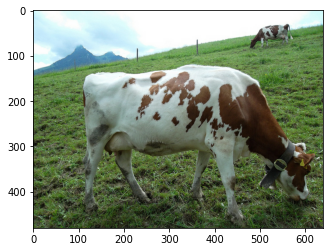

In [ ]:
plt.imshow(image)
plt.show()

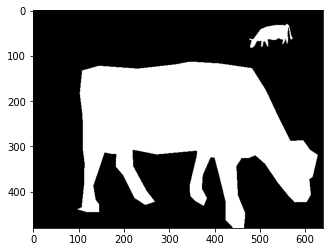

In [ ]:
plt.imshow(mask, cmap="gray")
plt.show()

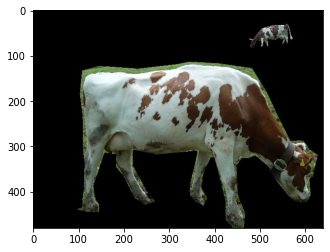

In [ ]:
segmented_image = image * tf.cast(mask[:, :, np.newaxis], tf.uint8)
plt.imshow(segmented_image)
plt.show()

In [ ]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SZIE = 100
SEED = 123
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128

def resize(input_image, input_mask):
    input_image = tf.image.resize(input_image, (IMAGE_HEIGHT, IMAGE_WIDTH))
    input_image = tf.reshape(input_image, (IMAGE_HEIGHT, IMAGE_WIDTH, 3))

    input_mask = tf.image.resize(input_mask, (IMAGE_HEIGHT, IMAGE_WIDTH))
    input_mask = tf.reshape(input_mask, (IMAGE_HEIGHT, IMAGE_WIDTH, 1))

    return input_image, input_mask

def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask = tf.cast(input_mask, tf.bool)

    return input_image, input_mask

def load_image_train(image_path, mask_path):
    input_image = tf.io.read_file(image_path)
    input_image = tf.image.decode_jpeg(input_image, channels=3)

    input_mask = tf.io.read_file(mask_path)
    input_mask = tf.image.decode_bmp(input_mask, channels=0)
    input_mask = input_mask[:, :, 0]
    input_mask = tf.expand_dims(input_mask, axis=-1)

    input_image, input_mask = resize(input_image, input_mask)
    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

def load_image_val(image_path, mask_path):
    input_image = tf.io.read_file(image_path)
    input_image = tf.image.decode_jpeg(input_image, channels=3)

    input_mask = tf.io.read_file(mask_path)
    input_mask = tf.image.decode_bmp(input_mask, channels=0)
    input_mask = input_mask[:, :, 0]
    input_mask = tf.expand_dims(input_mask, axis=-1)

    input_image, input_mask = resize(input_image, input_mask)
    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

def get_dataset_paths(image_dir, mask_dir):
    image_file_list = sorted(os.listdir(image_dir))
    mask_file_list = sorted(os.listdir(mask_dir))
    image_paths = [os.path.join(image_dir, filename) for filename in image_file_list]
    mask_paths = [os.path.join(mask_dir, filename) for filename in mask_file_list]

    return image_paths, mask_paths

def get_training_dataset(image_paths, mask_paths):
    training_dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    training_dataset = training_dataset.map(load_image_train)
    training_dataset = training_dataset.shuffle(SHUFFLE_BUFFER_SZIE, seed=SEED, reshuffle_each_iteration=True)
    training_dataset = training_dataset.cache()
    training_dataset = training_dataset.batch(BATCH_SIZE)
    training_dataset = training_dataset.prefetch(tf.data.AUTOTUNE)

    return training_dataset

def get_validation_dataset(image_paths, mask_paths):
    validation_dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    validation_dataset = validation_dataset.map(load_image_val)
    validation_dataset = validation_dataset.cache()
    validation_dataset = validation_dataset.batch(BATCH_SIZE)
    validation_dataset = validation_dataset.prefetch(tf.data.AUTOTUNE)

    return validation_dataset

In [ ]:
training_image_paths, training_mask_paths = get_dataset_paths(f"{IMAGES_PATH}/train/", f"{MASKS_PATH}/train/")
validation_image_paths, validation_mask_paths = get_dataset_paths(f"{IMAGES_PATH}/val/", f"{MASKS_PATH}/val/")
test_image_paths, test_mask_paths = get_dataset_paths(f"{IMAGES_PATH}/test", f"{MASKS_PATH}/test/")

training_dataset = get_training_dataset(training_image_paths, training_mask_paths)
validation_dataset = get_validation_dataset(validation_image_paths, validation_mask_paths)
test_dataset = get_validation_dataset(test_image_paths, test_mask_paths)

In [ ]:
print(f"Dataset de treino composto por {len(training_dataset)} batches")

for i, (x, y) in enumerate(training_dataset):
    print(f"batch {i}: X: {x.shape} Y: {y.shape}")
    if i > 10:
        break

Dataset de treino composto por 62 batches
batch 0: X: (32, 128, 128, 3) Y: (32, 128, 128, 1)
batch 1: X: (32, 128, 128, 3) Y: (32, 128, 128, 1)
batch 2: X: (32, 128, 128, 3) Y: (32, 128, 128, 1)
batch 3: X: (32, 128, 128, 3) Y: (32, 128, 128, 1)
batch 4: X: (32, 128, 128, 3) Y: (32, 128, 128, 1)
batch 5: X: (32, 128, 128, 3) Y: (32, 128, 128, 1)
batch 6: X: (32, 128, 128, 3) Y: (32, 128, 128, 1)
batch 7: X: (32, 128, 128, 3) Y: (32, 128, 128, 1)
batch 8: X: (32, 128, 128, 3) Y: (32, 128, 128, 1)
batch 9: X: (32, 128, 128, 3) Y: (32, 128, 128, 1)
batch 10: X: (32, 128, 128, 3) Y: (32, 128, 128, 1)
batch 11: X: (32, 128, 128, 3) Y: (32, 128, 128, 1)


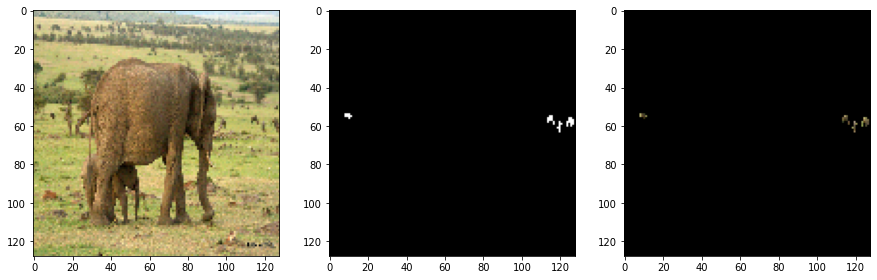

In [ ]:
sample_batch = next(iter(training_dataset))
image_idx = random.randrange(32)
sample_image = sample_batch[0][image_idx]
sample_mask = sample_batch[1][image_idx]

fig, axs = plt.subplots(1, 3, figsize=(15, 10))
axs[0].imshow(sample_image)
axs[1].imshow(sample_mask[:, :, 0], cmap="gray")
axs[2].imshow(tf.multiply(sample_image, tf.cast(sample_mask, tf.float32)))
plt.show()

## 3 - Definição e treinamento do modelo

In [ ]:
def double_conv_block(x, n_filters):
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)

    return x

def down_sample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.3)(p)

    return f, p

def up_sample_block(x, conv_features, n_filters):
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    x = layers.concatenate([x, conv_features])
    x = layers.Dropout(0.3)(x)
    x = double_conv_block(x, n_filters)

    return x

def unet(n_classes=1):
    inputs = layers.Input(shape=(128,128,3))

    # encoder: contracting path
    f1, p1 = down_sample_block(inputs, 64)
    f2, p2 = down_sample_block(p1, 128)
    f3, p3 = down_sample_block(p2, 256)
    f4, p4 = down_sample_block(p3, 512)

    # 5 - bottleneck
    bottleneck = double_conv_block(p4, 1024)

    # decoder: expanding path
    u6 = up_sample_block(bottleneck, f4, 512)
    u7 = up_sample_block(u6, f3, 256)
    u8 = up_sample_block(u7, f2, 128)
    u9 = up_sample_block(u8, f1, 64)

    # outputs
    if n_classes == 1:
        activation = "sigmoid"
    else:
        activation = "softmax"
    
    outputs = layers.Conv2D(n_classes, 1, padding="same", activation=activation)(u9)
    model = tf.keras.Model(inputs, outputs, name="U-Net")

    return model

In [ ]:
unet_model = unet()

In [ ]:
unet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
model_history = unet_model.fit(
    training_dataset, 
    epochs=50, 
    validation_data=validation_dataset
)
unet_model.save_weights("/content/drive/MyDrive/unet_weights2/unet_weights2")

Epoch 1/50
62/62 [==============================] - 657s 10s/step - loss: 0.3978 - accuracy: 0.8333 - val_loss: 0.3558 - val_accuracy: 0.8368
Epoch 2/50
62/62 [==============================] - 29s 473ms/step - loss: 0.3389 - accuracy: 0.8467 - val_loss: 0.3254 - val_accuracy: 0.8419
Epoch 3/50
62/62 [==============================] - 29s 460ms/step - loss: 0.3280 - accuracy: 0.8524 - val_loss: 0.3147 - val_accuracy: 0.8534
Epoch 4/50
62/62 [==============================] - 29s 468ms/step - loss: 0.3173 - accuracy: 0.8623 - val_loss: 0.3336 - val_accuracy: 0.8368
Epoch 5/50
62/62 [==============================] - 29s 464ms/step - loss: 0.3339 - accuracy: 0.8501 - val_loss: 0.3154 - val_accuracy: 0.8544
Epoch 6/50
62/62 [==============================] - 28s 458ms/step - loss: 0.3169 - accuracy: 0.8591 - val_loss: 0.2986 - val_accuracy: 0.8607
Epoch 7/50
62/62 [==============================] - 29s 463ms/step - loss: 0.2945 - accuracy: 0.8695 - val_loss: 0.2808 - val_accuracy: 0.8764


In [ ]:
# unet_model.load_weights(f"/content/drive/MyDrive/unet_weights/unet_weights")

## 4 - Testando nas nossas images

In [ ]:
unet_model.evaluate(test_dataset)

5/5 [==============================] - 97s 18s/step - loss: 1.3870 - accuracy: 0.7130


[1.3870095014572144, 0.7130434513092041]

1/1 [==============================] - 0s 19ms/step


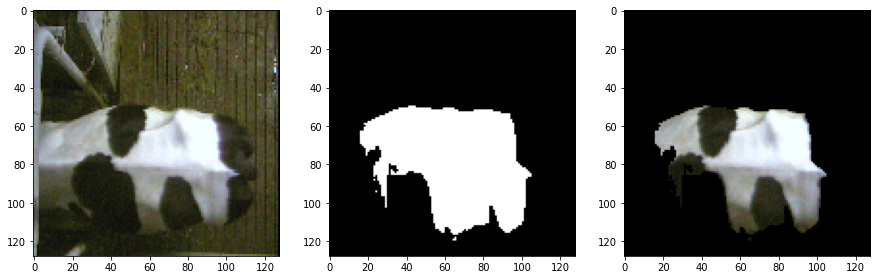

In [ ]:
test_image = tf.io.read_file(f"{IMAGES_PATH}/test/image139_bcs1_3.5_bcs2_3.5.jpg")
test_image = tf.image.decode_jpeg(test_image, channels=3)

test_image = tf.image.resize(test_image, (IMAGE_HEIGHT, IMAGE_WIDTH))
test_image = tf.reshape(test_image, (IMAGE_HEIGHT, IMAGE_WIDTH, 3))
test_image = tf.cast(test_image, tf.float32) / 255.0
test_image = tf.expand_dims(test_image, axis=0)

predicted_mask = unet_model.predict(test_image)
predicted_mask = np.where(predicted_mask < 0.5, 0, 1)

fig, axs = plt.subplots(1, 3, figsize=(15, 10))
test_image = tf.squeeze(test_image)
predicted_mask = predicted_mask[0, :, :, 0]
axs[0].imshow(test_image)
axs[1].imshow(predicted_mask, cmap="gray")
axs[2].imshow(test_image * tf.cast(predicted_mask[:, :, np.newaxis], tf.float32))
plt.show()

1/1 [==============================] - 0s 17ms/step


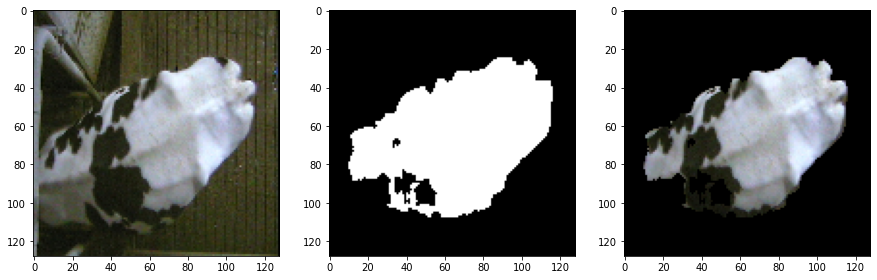

In [ ]:
test_image = tf.io.read_file(f"{IMAGES_PATH}/test/image149_bcs1_3_bcs2_3.25.jpg")
test_image = tf.image.decode_jpeg(test_image, channels=3)

test_image = tf.image.resize(test_image, (IMAGE_HEIGHT, IMAGE_WIDTH))
test_image = tf.reshape(test_image, (IMAGE_HEIGHT, IMAGE_WIDTH, 3))
test_image = tf.cast(test_image, tf.float32) / 255.0
test_image = tf.expand_dims(test_image, axis=0)

predicted_mask = unet_model.predict(test_image)
predicted_mask = np.where(predicted_mask < 0.5, 0, 1)

fig, axs = plt.subplots(1, 3, figsize=(15, 10))
test_image = tf.squeeze(test_image)
predicted_mask = predicted_mask[0, :, :, 0]
axs[0].imshow(test_image)
axs[1].imshow(predicted_mask, cmap="gray")
axs[2].imshow(test_image * tf.cast(predicted_mask[:, :, np.newaxis], tf.float32))
plt.show()